In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import re
plt.rcParams.update({'font.size': 14}) 

__I.Introduction(Growing tissues: A simulation study)__

__1.Model:__

In this model, two point particles represent each cell. These particles interact within a range $R_{PP}$, exhibiting forces that can be categorized into three types: intracellular forces, intercellular forces, and background forces. The force on particle i :
\begin{equation}
F_i = F^G_{ik}+F^D_{ik}+F^R_{ik} + \sum_{j\neq{i,k}}(F_{ij}^A+F_{ij}^V+F_{ij}^D+F_{ij}^R)+F_i^B
\tag{1}
\end{equation}

In the equation (1), i and k form a cell, and sum over j refers to interactions between particles in surrounding cells.

Growth force is:
\begin{equation}
F_{ik}^G= \frac{G}{(r_{ik}+r_0)^2}\hat{r_{ik}}
\tag{2}
\end{equation}

The volume exclusion force is:
\begin{equation}
F_{ij}^V = f_0(\frac{R_{PP}^5}{r_{ij}^5}-1)\hat{r_{ij}}
\tag{3}
\end{equation}

The dissipative force is:
\begin{equation}
F_{ij}^D = -\gamma \omega^D(r_{ij})(\hat{r_{ij}}v_{ij})\hat{r_{ij}}
\tag{4}
\end{equation}

The random force is:
\begin{equation}
F_{ij}^R = \sigma \omega^R(r_{ij})\epsilon_{ij}\hat{r_{ij}}
\end{equation}
with $\sigma = \sqrt{2k_BT\gamma}$, a Gaussian random variable $\epsilon_{ij}$ with zero mean and unit variance and a weight function $\omega^R(r_{ij}) = \sqrt{\omega^D(r_{ij})}$

The background dissipation force is:
\begin{equation}
F_i^B = -\gamma_b v_i
\end{equation}

__2.Homeostatic pressure__

Basan et al. [2009] introduce a new approach to describe the tissue competition driven by homeostatic pressure. The concept of homeostatic pressure can be best described by the following gedankenexperiment. Consider a tissue contained within a box, as illustrated in Figure 1.3. The walls of enclosure allow the nutrients, growth factors, and all necessary elements for tissue poliferation, maintaining a constant biochemical enviroment. Rather than having one wall, one side of the box is substituted with a movable piston linked to a spring. Within this setup, the cells divide at a rate denoted as $k_d$ and experience a death rate of $k_a<k_d$, therefore, filling the compartment. Once the tissue fills the box, it exerts pressure against the piston, which in turn applies a counter-pressure onto the tissue. As this pressure increases, the apoptosis rate rises while the division rate decreases, eventuallz reaching a stable state where $k_d=k_a$. This equilbrium state is robust, as any disturbance prompts the system to return to its stable, or homeostatic state. Within this state, both pressure(denoted as homeostatic pressure, $P_H$) and density(denoted as homeostatic density, $\rho_H$). These properties are fundamental to tissues and this motivate the expansion of total growth rate to the linear order of the difference of homeostatic pressure $P_H-P$ to external pressure.
\begin{equation}
k = \kappa (P_H-P) + \omicron((P_H-P)^2)
\end{equation}
or the difference of homeostatic density to actual density $\rho_H -\rho$
\begin{equation}
k = \chi (\rho_H-\rho) + \omicron((\rho_H-\rho)^2)
\end{equation}

The below picture cited from cite:http://www.tandfonline.com/doi/abs/10.2976/1.3086732. Homeostatic competition drives tumor growthand metastasis nucleation

<img src="./pictures/simple_tissue_competition.png" alt="Alt text" style="width:600px;">

__2.1 Homeostatic pressure dependence on model parameters__

The next step is to discuss the influence of the two model parameters, growth strength and adhesion strength, on the homeostatic pressure and to derive their relation through fitting simulation results.To study the effect of different model parameters on homeostatic pressure, we used PBC(perodic boundary condition) and pressure can be directly measured by varial theorem. In the paper,(Growing tissues: A simulation study), many model parameters has been discussed: growth strength, adhesion strength, compressibility and apoptosis rate. The results are: 

1. The higher the compressibility,the softer the tissue and the stronger the homeostatic pressure
2. Homeostatic pressure is almost independence with apoptosis rate in a large range.

In this analysis, I will fix the value of these two model parameters and won't study them right now, and only focus on the effect of growth strength and adhesion strength on homeostatic pressure.

The simulation set up are following:
The growth strength G are in the range of 30 to 40 with the interval of 1, the adhesion strength f1 are in the range of 5 to 7 with the interval of 0.5. The homeastatic pressure of each set-up is accuquired by averaging the measured virial pressure after tissue occupy the whole system.

Residual Sum of Squares (RSS): 1.4398408514499308
拟合参数：a = 0.8255197434137439, b = -4.433211634010404, c = 10.164378211438262
variance [[ 1.17923084e-04  5.77596434e-19 -4.06834640e-03]
 [ 5.77596434e-19  3.11316964e-03 -1.79007255e-02]
 [-4.06834640e-03 -1.79007255e-02  2.44259988e-01]]


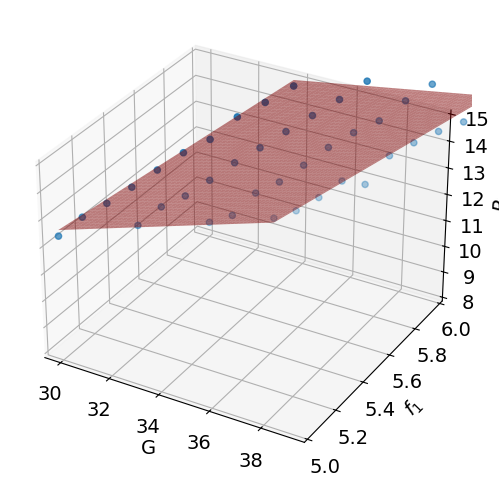

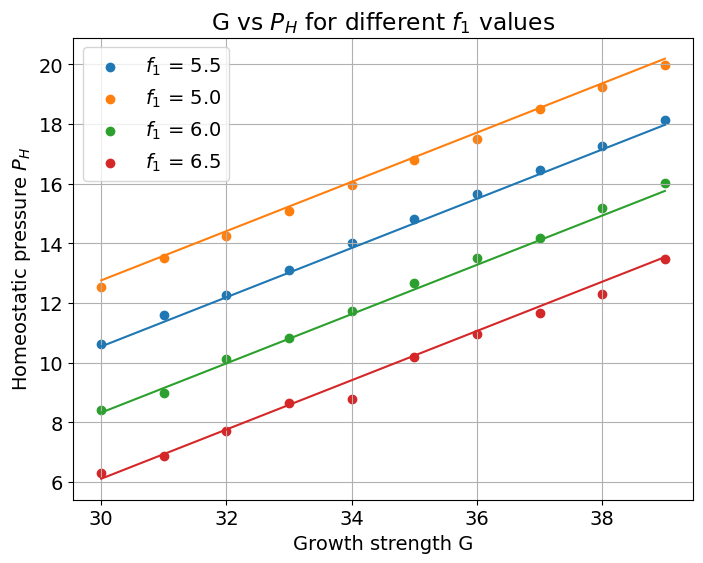

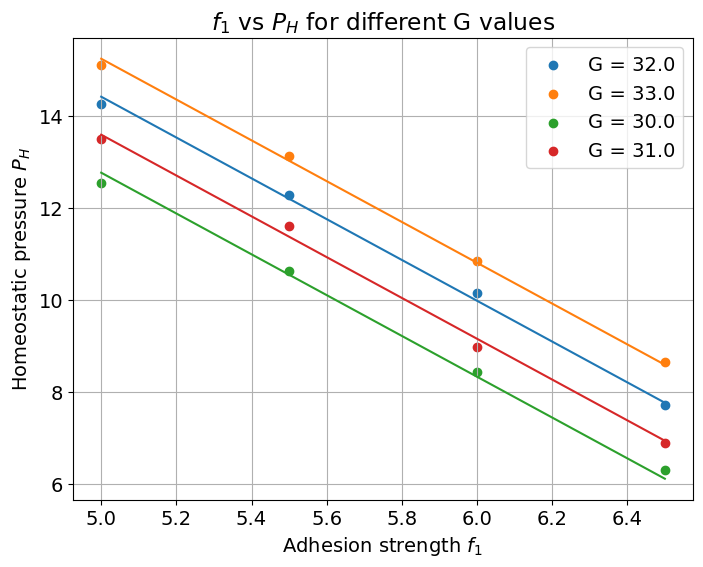

In [39]:
# 设置文件夹路径
folder_path = r'./2023-3-Homeostaticpressure-adhesion-growth/'
# 查找所有以G开头的文件夹
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('G')])
meas_time= 1500
# 存储数据的列表
G_values = []
f1_values = []
PH_values = []

# 遍历文件夹
for folder in folders[:-1]:
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('f1')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    for subfolder in sub_folders[:4]:
        ph_path = os.path.join(folder_path,folder,subfolder, '__curp.dat')
        # 读取P_H数据
        try:
            ph_data = pd.read_csv(ph_path,sep='\t')
        except:
            continue
            print('error here')
        PH = ph_data.iloc[-meas_time:,1].mean()
        PH_error = ph_data.iloc[-meas_time:,1].var()
        # 提取G和f1数值
        G = float(folder.split('_')[1])
        f1 = float(subfolder.split('_')[1])
        # 添加到列表中
        G_values.append(G)
        f1_values.append(f1)
        PH_values.append(PH)

# 将列表转换为数组
G_values = np.array(G_values)
f1_values = np.array(f1_values)
PH_values = np.array(PH_values)

# 绘制三维图像
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(G_values, f1_values, PH_values, label='Data')
ax.set_xlabel('G')
ax.set_ylabel('$f_1$')
ax.set_zlabel('$P_H$')

# 定义拟合函数
def fit_func(data, a, b, c):
    G, f1 = data
    return a * G + b * f1 + c

# 使用curve_fit拟合数据
params, _ = curve_fit(fit_func, (G_values, f1_values), PH_values)

# 提取拟合参数
a_fit, b_fit, c_fit = params
predicted_values = fit_func((G_values, f1_values), *params)
RSS = np.sum((PH_values - predicted_values)**2)
print("Residual Sum of Squares (RSS):", RSS)

# 打印拟合参数
print(f'拟合参数：a = {a_fit}, b = {b_fit}, c = {c_fit}')

# 生成拟合曲面数据
G_fit = np.linspace(G_values.min(), G_values.max(), 100)
f1_fit = np.linspace(f1_values.min(), f1_values.max(), 100)
G_fit, f1_fit = np.meshgrid(G_fit, f1_fit)
P_H_fit = fit_func((G_fit, f1_fit), a_fit, b_fit, c_fit)

# 绘制拟合曲面
ax.plot_surface(G_fit, f1_fit, P_H_fit, alpha=0.5, color='red', label='Fit')

equation = f"$P_H$ = {a_fit} * G + {b_fit} * $f_1$ + {c_fit}"
#ax.text2D(0.05, 0.95, equation, transform=ax.transAxes)
print('variance',_)
ax.set_zlim(8, 15)
ax.set_ylim(5,6)

def PH_func(G,f1, a=a_fit, b=b_fit, c=c_fit):
    return a * G + b * f1 + c
# 按照 G 值分别绘制散点图
unique_f1_values = set(f1_values)

plt.figure(figsize=(8, 6))  # 设置图形大小

# 遍历不同的 G 值
for f1 in unique_f1_values:
    # 找到对应 G 值的数据索引
    indices = [i for i, value in enumerate(f1_values) if value == f1]
    # 根据索引获取对应的 f1 和 PH 值
    G_subset = [G_values[i] for i in indices]
    G_fit = np.linspace(np.min(G_subset),np.max(G_subset),100)
    PH_subset = [PH_values[i] for i in indices]
    PH_fit = PH_func(G_fit,f1,a_fit,b_fit,c_fit)
    plt.plot(G_fit,PH_fit)
    # 绘制散点图
    plt.scatter(G_subset, PH_subset, label=f'$f_1$ = {f1}')

plt.xlabel('Growth strength G')
plt.ylabel('Homeostatic pressure $P_H$')
plt.legend()
plt.title('G vs $P_H$ for different $f_1$ values')
plt.grid(True)
plt.show()

G_values = []
f1_values = []
PH_values = []

# 遍历文件夹
for folder in folders[:4]:
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('f1')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    for subfolder in sub_folders[:-1]:
        ph_path = os.path.join(folder_path,folder,subfolder, '__curp.dat')
        # 读取P_H数据
        try:
            ph_data = pd.read_csv(ph_path,sep='\t')
        except:
            continue
            print('error here')
        PH = ph_data.iloc[-meas_time:,1].mean()
        PH_error = ph_data.iloc[-meas_time:,1].var()
        # 提取G和f1数值
        G = float(folder.split('_')[1])
        f1 = float(subfolder.split('_')[1])
        # 添加到列表中
        G_values.append(G)
        f1_values.append(f1)
        PH_values.append(PH)
# 按照 G 值分别绘制散点图
unique_G_values = set(G_values)

plt.figure(figsize=(8, 6))  # 设置图形大小

# 遍历不同的 G 值
for g in unique_G_values:
    # 找到对应 G 值的数据索引
    indices = [i for i, value in enumerate(G_values) if value == g]
    # 根据索引获取对应的 f1 和 PH 值
    f1_subset = [f1_values[i] for i in indices]
    f1_fit = np.linspace(np.min(f1_subset),np.max(f1_subset),100)
    PH_subset = [PH_values[i] for i in indices]
    PH_fit = PH_func(g,f1_fit)
    # 绘制散点图
    plt.scatter(f1_subset, PH_subset, label=f'G = {g}')
    plt.plot(f1_fit,PH_fit)

plt.xlabel('Adhesion strength $f_1$')
plt.ylabel('Homeostatic pressure $P_H$')
plt.legend()
plt.title('$f_1$ vs $P_H$ for different G values')
plt.grid(True)


From the simulation results, we can use a formula to represent an approximation of $P_H$ as a linear expansion of two variables,G and f1, around a reference point $(G(0),f_1(0))$

\begin{equation}
P_H \approx a*(G-G(0))+b*(f_1-f_1(0))+c_0 = a*G + b*f_1 + c
\end{equation}

And the approximation formula is:
\begin{equation}
P_H \approx 0.8375581684402741 * G + -4.1535432645330195 * f1 + 8.256289599112424
\end{equation}

In the following analysis, I will fix the value of a,b and c.

__3.Simple competition theory__

In simple competition theory, the concept of homeostatic pressure is originally used to explain the competition of two species.The fraction of the specie with higher homeostatic pressure will follows the logistic manner and outcompete the competition. The simulation of competition between two species with different homeostatic pressure will be conducted to examine the thoery.

__3.1 Theory__

With the assumption of incompressibility of tissue and identical pressure response $\kappa$ of both tissues, the total cell number $N_{tot} = N_A +N_B$ is conserved and $\kappa_A = \kappa_B = \kappa$. The dynamical system is:
\begin{equation}
\partial_t N_A = \kappa(P_H^A-P)N_A
\end{equation}

\begin{equation}
\partial_t N_B = \kappa(P_H^B-P)N_B
\end{equation}

Divide the two sides of both equations by $N_{tot}$

\begin{equation}
\partial_t \phi = \kappa(P_H^A-P)\phi
\end{equation}

\begin{equation}
\partial_t (1-\phi) = \kappa(P_H^B-P)(1-\phi)
\end{equation}

Sum up the above two equations, we can get the relation between P and $\phi$:
\begin{equation}
P = P_H^A \phi + P_H^B (1-\phi)
\end{equation}

Plug the formula of P into one of dynamical system equation, we get:
\begin{equation}
\partial_t \phi = \kappa (P_H^A- P_H^B)\phi(1-\phi) = \kappa \Delta P_H \phi(1-\phi)
\end{equation} 

The general solution of the above differential equation is:
\begin{equation}
\phi = \frac{1}{1+e^{-\kappa \Delta P_H (t-t_0)}}
\end{equation}
__3.2 Simulation__

To research on the simple tissue competition case, the simulation set up are following:
Keep the $f_1=f_1^A=f_1^B$ but change $f_1$ in the range of 5 to 6 with the interval of 1.
In each adhesion strength $f_1$, I fix the $G_B=35$ and change $G_A$ in the range of 35.5 to 37.5 with the interval of 0.5(small deviation around reference value). 

In the simulation, the initial fraction of specie A $\phi$ is always 0.05. 
Our goal is to curvefit the $\phi$ as a function of time, therefore $\kappa \Delta P_H$ can be acquired. $\Delta P_H$ can be directly calculated by the formula of $P_H$ linear approximation. Thus we can plot a picture of $\kappa \Delta P_H$ as a function of $\Delta P_H$, and the slope of the data is expected as around $\kappa$ by this theory.  



<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\k'
<>:55: SyntaxWarning: invalid escape sequence '\k'
<>:57: SyntaxWarning: invalid escape sequence '\k'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\k'
<>:55: SyntaxWarning: invalid escape sequence '\k'
<>:57: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_252735/3386301590.py:50: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta P_H$')
/tmp/ipykernel_252735/3386301590.py:51: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('$\kappa \Delta P_H$')
/tmp/ipykernel_252735/3386301590.py:55: SyntaxWarning: invalid escape sequence '\k'
  plt.title('f1 vs $\kappa$')
/tmp/ipykernel_252735/3386301590.py:57: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('$\kappa$')
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufu

Text(0, 0.5, '$\\kappa$')

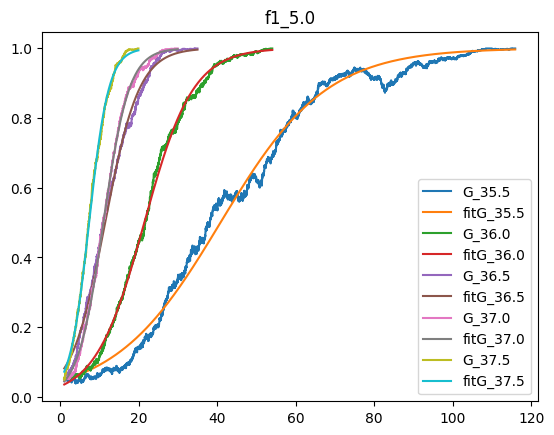

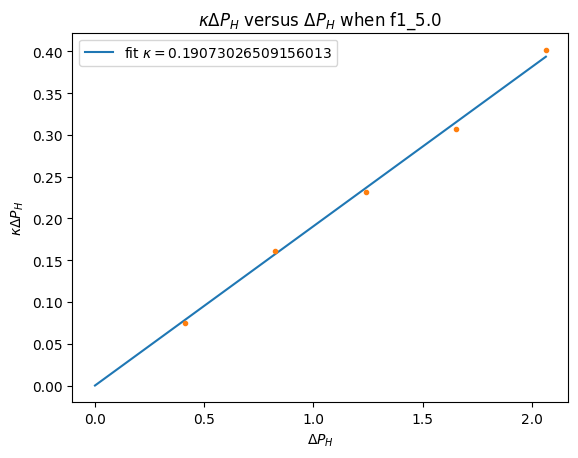

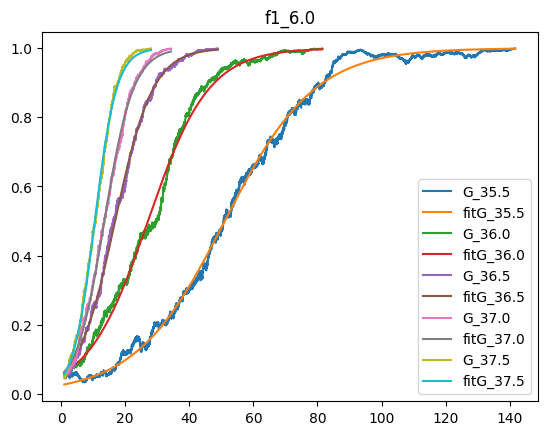

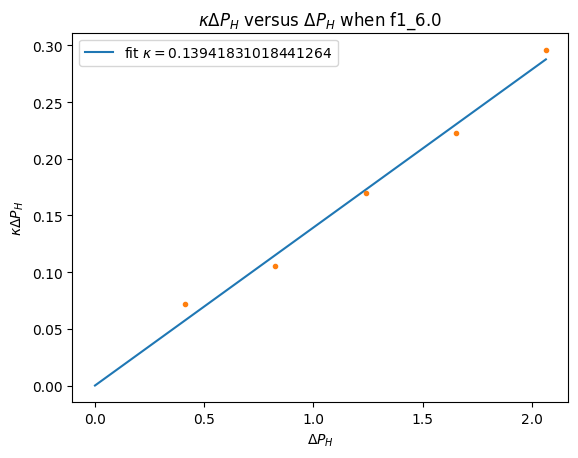

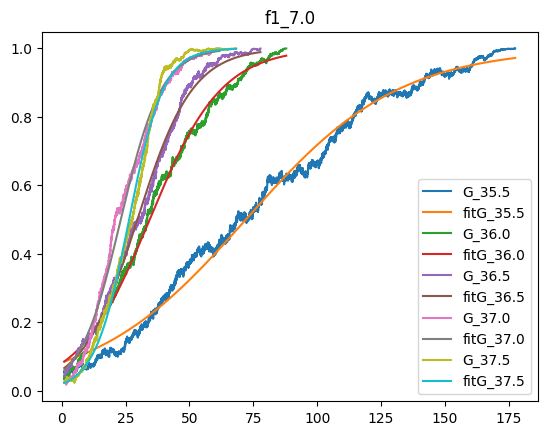

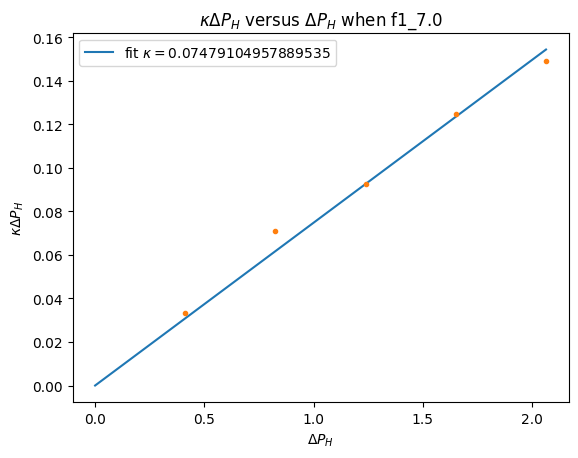

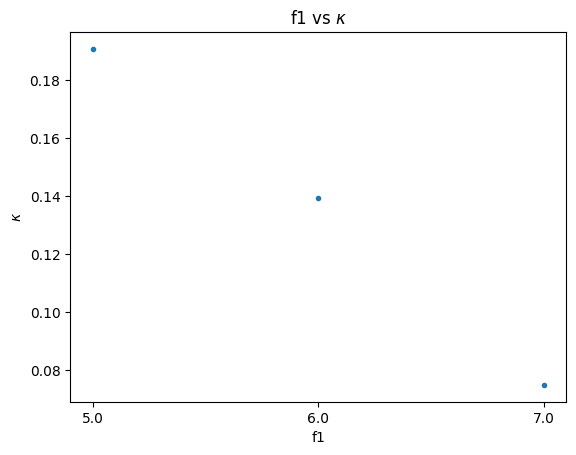

In [3]:
# Constants
a = a_fit
b = -b_fit

def fit_func(t,kph,t0):
    phi = 1/(1+np.exp(-kph*(t-t0)))
    return phi

def fit_kappa(ph,kappa):
    kph = kappa*ph
    return kph
folder_path = r'./2023-11-simple-competition'
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
kappa_list = []
f1_list = []
for folder in folders:
    f1_list.append(folder.split('_')[-1])
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    plt.figure()
    kph_list = []
    deltaph_list = []
    for sub_folder in sub_folders:
        numcells_path = os.path.join(folder_path,folder,sub_folder, 'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            time_data = numcells_data['time'][100:]
            fraction_data = numcells_data['fraction'][100:]
            plt.plot(time_data,fraction_data,label=str(sub_folder))
            plt.title(str(folder))
            popt,pcov = curve_fit(fit_func,time_data,fraction_data)
            fit_fraction_data = fit_func(time_data,*popt)
            plt.plot(time_data,fit_fraction_data,label='fit'+str(sub_folder))
            kph,deltaph = popt[0],(float(sub_folder.split('_')[1])-35)*a
            kph_list.append(kph)
            deltaph_list.append(deltaph)
        except:
            continue
    plt.legend()
    plt.figure()
    popt,_ = curve_fit(fit_kappa,deltaph_list,kph_list)
    kappa_list.append(popt[0])
    deltaph_fit = np.linspace(0,np.max(deltaph_list),100)
    kph_fit = fit_kappa(deltaph_fit,*popt)
    plt.plot(deltaph_fit,kph_fit,label = r"fit $\kappa=$"+str(popt[0]))
    plt.plot(deltaph_list,kph_list,'.')
    plt.title(r'$\kappa \Delta P_H$ versus $\Delta P_H$ when '+str(folder))
    plt.xlabel('$\Delta P_H$')
    plt.ylabel('$\kappa \Delta P_H$')
    plt.legend()
plt.figure()
plt.plot(f1_list,kappa_list,'.')
plt.title('f1 vs $\kappa$')
plt.xlabel('f1')
plt.ylabel('$\kappa$')

<img src="./pictures/kappa.png" alt="Alt text" style="width:600px;">

__3.3 Result__

As what the theory expected, $\kappa \Delta P_H$ has a linear relation with $\delta P_H$, but the slope in different $f_1$ is not the same. Does it mean they have different pressure response coefficient $\kappa$ in different $f_1$?  In the thesis (Growing tissues: A simulation study), the value of slope $\kappa$ around zero pressure difference is quite stable with different growth and self adhesion strength. So the answer of the question is no. 

The following question is: what does make the slope different? The reason is: In the simple tissue competition, we neglect the effect of interfacial effect of two tissue even if the cross and self adhesion strength of two species are same ($f_1^A = f_1^B = f_c$). And this is the reason why the theory of simple tissue competition is limited.

__4. Rock-Paper-Scissor__

The main topic of this thesis is to find out and explain the intranstive relation, which Rock-paper-Scissor as a great example to describe and cannot be explained by simple competition theory in tissue competition.

A homogeneous relation R on the set X is a transitive relation if, for all $a,b,c \in X$, if a R b and b R c, then a R c. The common transitive relation R in mathematics can be "is greater than","is equal to","is at least as great as" and so on.
A relation R is called intransitive if it is not transitive.(https://en.wikipedia.org/wiki/Transitive_relation)

In biology competition, the transitive relation R can be "outcompete","advantagely coexisent","equally coexisent" and so on. If the relation R "outcompete" is not transitive, like what the rule of rock-paper-scissor game , rock wins scissor, scissor wins paper and paper wins rock, does this scenerio exist in tissue competition? In the theory of simple tissue competition, the species with higher homeostatic pressure always win the competition and the concept of homeostatic pressure in tissue competition is equivalent to the concept of fitness in evolution theory.  So the rock-paper-scissor scenerio can never be acheived under theory of simple tissue competition.

But as what I mentioned in the section (3. Simple tissue competition), the theory of simple tissue competition doesn't consider the interfacial effect, which may totally change the competition result. So I will mainly discuss the interfacial effect in next chapter.

__II. Interfacial effect__

Before I discuss the interfacial effect in tissue competiton, I will list two papers, which  have already shown some interesting simulation results and fully discussed about this effect. Here I will simply repeat the simulation, apply the theory and rethink of them.   

__1.Coexistence in flat interfaces  (Mechanics of tissue competition: interfaces stabilize coexistence)__


__1.1 Result__

In the paper, the simulation based on the same 2-particle model with considering different forces like growth force,adhesion force,dissipative force,volume exclusion force and so on. The fundamental set up of the simulation is $f_c<<min(f_1^{AA},f_1^{BB})$. Under this condition, instead of one tissue overcompetes the other due to different homeostatic pressure, a stable coexistence of two segregated tissue could be observed.


__1.2 Theory__


In oreder to understand the mechanics of this behavaviour better, a simple arrangement that two tissue seperated by a flat interface is used. Here we only focus on 2d PBC case. Left half part of the system is filled with type A cells, the other part type B. High adhesion among cells within the same tissue and low adhesion between cells from different tissues result in increased interfacial tension, thereby stabilizing the interface. Due to the low adhesion around the interface, cells divide more in the region of interface than tissue bulk, thus the growth rate of tissue bulk is negative when the whole system reaches to equilibruim state. These observations motivate a two-rate growth model. Our model tissue behaves as a liquid thus we can assume a constant pressure and density($\rho_0$) across the system. Thus we get the dynamical system of tissue A:
\begin{equation}
\partial_t N_A = k_b^A N^A + \Delta k_s^A \rho_0 2a L_x L_y
\end{equation}
Due to the constant density across the system, the total number of cell A and B ($N=N_A+N_B = \rho_0 L_x L_y L_z$)is constant. Divide the equation above and obtain
\begin{equation}
\partial_t \phi =k_b^A \phi +2a\Delta k_s^A/L_z
\end{equation}

\begin{equation}
\partial_t (1-\phi) = k_b^B(1-\phi)+2a\Delta k_s^B/L_z
\end{equation}

**I don't know why the homogeneous pressure motivates the linear dependence of $k_b$ on ($P_H-P$), thus $\Delta k_s \approx \Delta k_s^0 + \Delta k_s^1 (P_H - P)$**

We first consider the case of two idential tissue. Including the linear pressure dependence of $k_b$​ and $\Delta k_s$​ in above two equations yield the pressure:
\begin{equation}
P = P_H +\frac{4a\Delta k_s^0}{4a\Delta k_S^1 +\kappa L_z}
\end{equation}
Insert the formula of Pressure into two dynamical equations, we obtain the general solution of the tissue A fraction:
\begin{equation}
\phi(t) = \frac{1}{2}+(\phi_0 - \frac{1}{2})e^{-\kappa(P-P_H)t}
\end{equation}

with the intial fraction $\phi_0$. Therefore, the fraction of two idential tissues with zero cross-adhesion will relax expontentially towards 1/2.

To determine the interface growth coefficients $a \Delta k_{s0}$​ and $\Delta k_{s1}$, we employ mirror boundary conditions.


In [4]:
# Constants
a = a_fit
b = -b_fit
c = c_fit

def fit_plz(lz,ak0,ak1):
    difph = 4*ak0/(4*ak1+lz)
    return difph
# 设置文件夹路径
current_path = r'./2023-12-flat-interface'
# 查找所有以G开头的文件夹
folders = sorted([f for f in os.listdir(current_path) if os.path.isdir(os.path.join(current_path, f)) and f.startswith('f1')])

# 遍历文件夹
for folder in folders:
    folder_path = os.path.join(current_path, folder)
    sub_folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(current_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    folder_number = float(folder.split('_')[1])
    plt.figure()
    for subfolder in sub_folders:
        print(folder_path,subfolder)
        subnumber = float(subfolder.split('_')[1])     
        subfolder_path = os.path.join(folder_path,subfolder)
        subsubfolders = sorted([f for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(folder_path,subfolder, f)) and f.startswith('LZ')])
        subsubfolders.sort(key=lambda x: float(x.split("_")[1]))
        subsubnumber_list = []
        result_list = []
        PH = a*subnumber-b*folder_number+c
        for subsubfolder in subsubfolders:
            subsubnumber = 1/float(subsubfolder.split('_')[1])/2
            ph_path = os.path.join(subfolder_path,subsubfolder, '__curp.dat')
            # 读取P_H数据
            try:
                ph_data = pd.read_csv(ph_path,sep='\t')
            except:
                continue
            P = ph_data.iloc[300:,1].mean()
            subsubnumber_list.append(subsubnumber)
            result_list.append(P)
        plt.plot(subsubnumber_list,result_list,'.',label=subfolder)
        plt.xlabel('$1/L_z$')
        plt.ylabel('Pressure')
        plt.title('The relation between pressure and $1/L_z$ when '+folder)
        plt.axhline(y=PH,label='PH when '+subfolder,linestyle='--')
        plt.legend()
        plt.figure()
        time_data = ph_data.iloc[:,0]
        p_data = ph_data.iloc[:,1]
        plt.plot(time_data,p_data)
        plt.title(folder+subfolder+subsubfolder)
        plt.xlabel('time')
        plt.ylabel('pressure')



__2.Mechanical interplay of adhesion(Tissue evolution: mechanical interplay of adhesion, pressure, and heterogeneity)__

__2.1 Simulation model__



For a scenario with two cell types, A and B, existing in the system,, the average single pressure reduction due to adhesion for cell A ($P_{ad}^A$) can be approximated as:
$$P_{ad}^A \propto \sum_{neigh\ cell\ i}f_1^i \propto \phi f_1^A + (1-\phi)f_1^c$$
, where $\phi$ is the fraction of specie A in the whole population,$f_1^c$ is the cross adhesion strength between specie A and B. Here I used the mean field approximation and assumed specie A and B are well mixed.

Similarly, for cell B ($P_{ad}^B$)
$$P_{ad}^B \propto (1-\phi) f_1^B + \phi f_1^c$$

The average pressure $$P^A = P_{inner}^A- P_{ad}^A+ P_{vol}^A,\ P^B = P_{inner}^B- P_{ad}^B+ P_{vol}^B$$ The average pressure difference $$\Delta P = P^A-P^B = \Delta P_{inner}- \Delta P_{ad} $$
where $\Delta P_{inner} \propto \Delta G$,$\Delta P_{ad} \propto  (1-\phi)(f_1^C-f_1^B)+\phi (f_1^A-f_1^C)$, 

$\Delta P$ not only measures the average pressure difference between two species under the current competition, but also measures the strength of advantage of species A over species B.

$$\Delta P(\phi)=a*\Delta G - b *[(1-\phi)(f_1^C-f_1^B)+\phi (f_1^A-f_1^C)]$$

Take out all the $\phi$ of this formula as one term:

$$\Delta P(\phi)= b(2f_1^C-f_1^A-f_1^B)\phi + a\Delta G + b(f_1^B-f_1^C)$$
, where a = 0.83 ,b = 4.4253


Using the result of simple tissue competition $\frac{\partial \phi}{\partial t} = \kappa \Delta P \phi(1-\phi)$，substituting the formula $\Delta_P$ into the above equation, we can get a dynamical system equation about $\phi$.

There are three fixed points in this dynamical system (when $\frac{\partial \phi}{\partial t}=0$), the first two fixed point are obvious: $\phi_1 = 0, \phi_2 =1$. The third FP can only be obtained when $\Delta P= 0$
The third FP: $$\phi_3 = \frac{\frac{a\Delta G}{b}-f_1^C+f_1^B}{f_1^A+f_1^B-2f_1^C}$$

The stability of the FP is determined by the sign of $b(2f_1^C-f_1^A-f_1^B)$. It's stable if sign is - and vice verse.

__Paper 1:Mechanics of tissue competition:interfaces stabilize coexistence__

Let's simply apply this theory to the previous results of tissue competition. In the paper '2019 M Ganai et al, Mechanics of tissue competition: interfaces stabilize coexistence',the number fractions of two identical tissues with zero cross adhesion will relax exponentially towards 1/2. 

To test this framework, I set $f_1^A = 5,f_1^B =5,\Delta G =0$, and plot the formula of $\phi_3$ with the relation of $f_1^C$

/tmp/ipykernel_252735/746415636.py:10: RuntimeWarning: invalid value encountered in divide
  return (a/b*deltaG-fc+f1B)/(f1A+f1B-2*fc)


(0.0, 1.0)

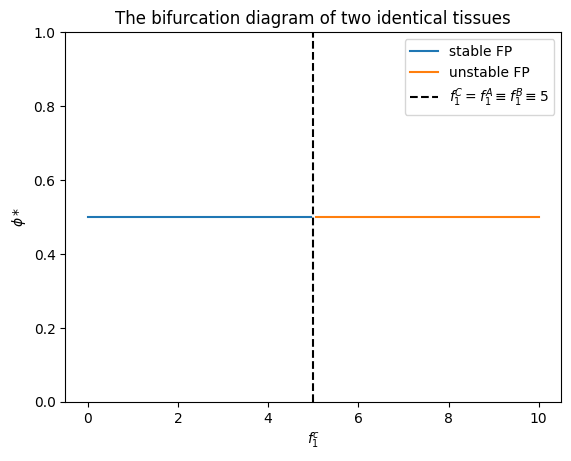

In [5]:
# Constants
a = a_fit
b = -b_fit

f1A = 5
f1B = 5
deltaG=0

def func_phi3(fc,deltaG,f1A,f1B):
    return (a/b*deltaG-fc+f1B)/(f1A+f1B-2*fc)
fc_space_stable = np.linspace(0,(f1A+f1B)/2,100)
fc_space_unstable = np.linspace((f1A+f1B)/2,10,100)
phi3_space_stable = func_phi3(fc_space_stable,deltaG,f1A,f1B)
phi3_space_unstable = func_phi3(fc_space_unstable,deltaG,f1A,f1B)
plt.plot(fc_space_stable,phi3_space_stable,label='stable FP')
plt.plot(fc_space_unstable,phi3_space_unstable,label='unstable FP')
plt.axvline(x=f1A,ls='--',color='black',label=r'$f_1^C =f_1^A \equiv f_1^B \equiv 5$')
plt.legend()
plt.title('The bifurcation diagram of two identical tissues')
plt.xlabel(r'$f_1^c$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)

It's easy to see that the fixed point is $\phi_3 = 0.5$ and the bifurcation point is $f_1^C =f_1^A =5$, which means $\phi_3$ is a stable FP when $f_1^C <5$ and vice versa. 

<img src="./pictures/Ganai_et_al.jpg" alt="Alt text" style="width:600px;">

Later, the paper continue to explore the competition between two tissues with different homeostatic pressures.

(0.0, 1.0)

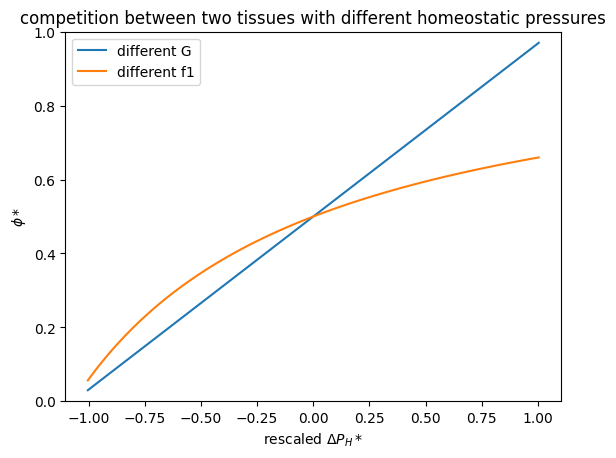

In [6]:
# Constants
a = a_fit
b = -b_fit
f1A = 6
f1B = 6
fc=0
deltaplim= 25

G=50
P_H = 0.8295815090071099 * G  -4.425285321119238 * f1A + 9.984763647732978

def func_phi3(fc,deltaG,f1A,f1B):
    return (a/b*deltaG-fc+f1B)/(f1A+f1B-2*fc)
deltap_space = np.linspace(-deltaplim,deltaplim,100)
#When f1 is same, delta p = a *delta G => deltaG = delta p / a 
phi3_space_difG = func_phi3(fc,deltap_space/a,f1A,f1B)
#When G is same and f1A=5, delta p = -b(f1A-f1B) => f1B = f1A+ delta P/b
phi3_space_diff1= func_phi3(fc,0,f1A,f1A+deltap_space/b)

plt.plot(deltap_space/P_H,phi3_space_difG,label='different G')
plt.plot(deltap_space/P_H,phi3_space_diff1,label='different f1')
plt.legend()
plt.title('competition between two tissues with different homeostatic pressures')
plt.xlabel(r'rescaled $\Delta P_H*$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)


<img src="./pictures/Ganai_et_al1.png" alt="Alt text" style="width:600px;">

Comparing the two theoretical results and simulation results, the theory here didn't fit the simulation well because two tissues with zero cross-adhesion can't be mixed, which disobey the assumption of the theory. But this theory shows the correct trendency with $\Delta P_H$.

Borrowing the idea of two-rate model, the tissue can be seperated by surface and bulk part:

The Bulk pressure of tissue A is same as the homeostatic pressure of itself
$$P_H^A = a G_A - b f_1^A + c$$

The surface pressure of tissue A contacing with B;
$$P_S^A = a G_A-b[\phi_0 f_1^A +(1-\phi_0)f_1^C]+c$$
The hemostatic pressure of tissue A with the influence of cross adhesion:
$$P^A(x) = \sum_i P^A_i \phi_i = (1- \frac{r}{x}) P_H^A+ \frac{r}{x} P_S^A$$
, where r is the surface length in two-rate model and L is system length,$\phi_0$ is the ratio of identical cells to surrounding cells on the interface, I assume $\phi_0$ = 5/8 in the program.

With the same idea, we can get the bulk,surface and homeostatic pressure of tissue B
$$P_H^B = a G_B - b f_1^B + c$$
$$P_S^B = a G_B-b[\phi_0 f_1^B +(1-\phi_0)f_1^C]+c$$
$$P^B(x) = \sum_i P^B_i \phi_i =(1-\frac{r}{L-x}) P_H^B+ \frac{r}{L-x} P_S^B = P_H^B +\frac{r}{L-x}(P_S^B-P_H^B)$$


The bulk,surface and homeostatic pressure difference of tissue A and B:
$$\Delta P_H = a\Delta G-b \Delta f_1$$
$$\Delta P_S = a\Delta G -\phi_0 b \Delta f_1$$
$$\Delta P(x) = \Delta P_H + r(\frac{P_S^A-P_H^A}{x}-\frac{P_S^B-P_H^B}{L-x}) = \Delta P_H + r(\frac{\Delta P^A}{x}-\frac{\Delta P^B}{L-x})$$
,where $\Delta P^A$ and $\Delta P^B$ represents the net surface pressure from cross adhesion force.
$$\Delta P^A = P_S^A-P_H^A = b(1-\phi_0)(f_1^A-f_1^C)$$
$$\Delta P^B = P_S^B-P_H^B = b(1-\phi_0)(f_1^B-f_1^C)$$

>Using the result of simple tissue competition $\frac{\partial \phi}{\partial t} = \kappa \Delta P \phi(1-\phi)$，substituting the formula $\Delta P$ into the above equation, we can get a dynamical system equation about $\phi$.
>There are three fixed points in this dynamical system (when $\frac{\partial \phi}{\partial t}=0$), the first two fixed point are obvious: $\phi_1 = 0, \phi_2 =1$. The third FP can only be obtained when $\Delta P= 0$

We can transfer x to $\phi$ by the formula $\phi = x/L$
The FP can be calculated by $$\Delta P(x^*) = 0$$
The stability of the FP can be determined by $$\frac{d}{dx} \Delta P(x) \Big|_{x=x^*} = -r[\frac{\Delta P^A}{x^2}+\frac{\Delta P^B}{(L-x)^2}]<0 \Big|_{x=x^*} ,\forall x^*$$
So all FPs we get from $\Delta P(x^*) = 0$ are stable. And the solution of this equation is:
$$x^* = \frac{\Delta P_H L -(\Delta P^A+\Delta P^B)r+\sqrt{4\Delta P^A \Delta P_H L r + [\Delta P_H L-(\Delta P^A+\Delta P^B)r]^2}}{2 \Delta P_H}$$
$$\phi* = x^*/L$$

(0.0, 1.0)

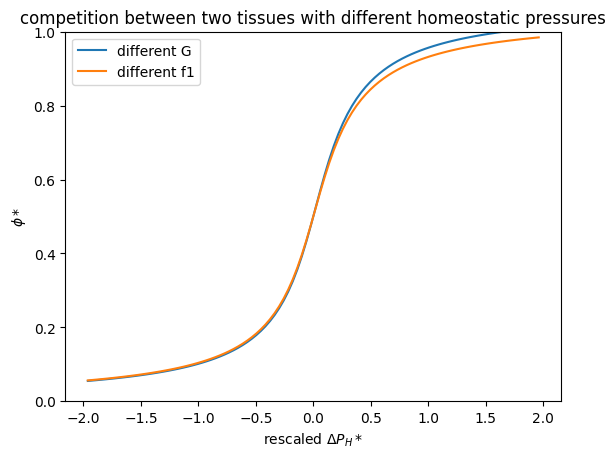

In [7]:
# Constants
a = a_fit
b = -b_fit
c = c_fit
L = 40 #system size
r = 3 #surface length
f1A = 5
f1B = 5
fc=0
GA=30
GB=30
phi0= 5/8 # The fraction of same type of the surface within the neighbors,


deltaplim= 25


P_H = 0.8295815090071099 * GA  -4.425285321119238 * f1A + 9.984763647732978

def func_phi(fc,GA,GB,f1A,f1B,L,r):
    deltaph = a*(GA-GB)-b*(f1A-f1B)
    PSA= a*GA -b*(f1A*phi0+fc*(1-phi0))+c
    PSB= a*GB -b*(f1B*phi0+fc*(1-phi0))+c
    x=(deltaph*L-(PSA+PSB)*r + np.sqrt(4* PSA*deltaph*L*r+(deltaph*L-(PSA+PSB)*r)**2))/(2*deltaph)
    return x/L

deltap_space = np.linspace(-deltaplim,deltaplim,100)
#When f1 is same, delta p = a *delta G => deltaG = delta p / a 
phi3_space_difG = func_phi(fc,GA,GA-deltap_space/a,f1A,f1B,L,r)
#When G is same and f1A=5, delta p = -b(f1A-f1B) => f1B = f1A+ delta P/b
phi3_space_diff1= func_phi(fc,GA,GB,f1A,f1A+deltap_space/b,L,r)

plt.plot(deltap_space/P_H,phi3_space_difG,label='different G')
plt.plot(deltap_space/P_H,phi3_space_diff1,label='different f1')
plt.legend()
plt.title('competition between two tissues with different homeostatic pressures')
plt.xlabel(r'rescaled $\Delta P_H*$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)


<img src="./pictures/Ganai_et_al1.png" alt="Alt text" style="width:600px;">

(0.0, 1.0)

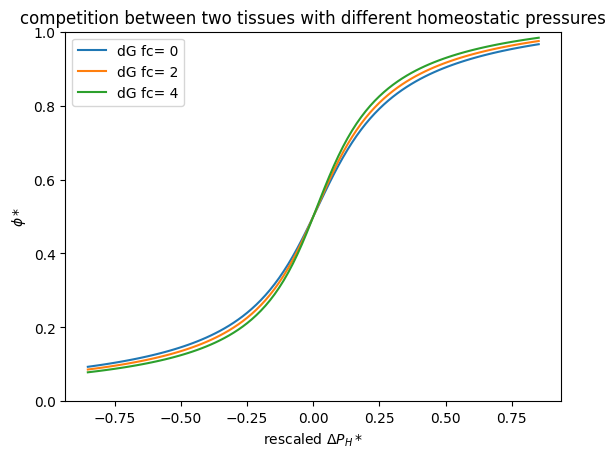

In [8]:
# Constants
a = a_fit
b = -b_fit
c = c_fit
L = 40 #system size
r = 3 #surface length
f1A = 5
f1B = 5
fc=0
GA=50
GB=50
phi0= 5/8 # The fraction of same type of the surface within the neighbors,


deltaplim= 25


P_H = 0.8295815090071099 * GA  -4.425285321119238 * f1A + 9.984763647732978

def func_phi(fc,GA,GB,f1A,f1B,L,r):
    deltaph = a*(GA-GB)-b*(f1A-f1B)
    PSA= a*GA -b*(f1A*phi0+fc*(1-phi0))+c
    PSB= a*GB -b*(f1B*phi0+fc*(1-phi0))+c
    x=(deltaph*L-(PSA+PSB)*r + np.sqrt(4* PSA*deltaph*L*r+(deltaph*L-(PSA+PSB)*r)**2))/(2*deltaph)
    return x/L

deltap_space = np.linspace(-deltaplim,deltaplim,100)
fc_list =[0,2,4]

for fc in fc_list:
    #When f1 is same, delta p = a *delta G => deltaG = delta p / a 
    phi3_space_difG = func_phi(fc,GA,GA-deltap_space/a,f1A,f1B,L,r)
    #When G is same and f1A=5, delta p = -b(f1A-f1B) => f1B = f1A+ delta P/b
    phi3_space_diff1= func_phi(fc,GA,GB,f1A,f1A+deltap_space/b,L,r)
    plt.plot(deltap_space/P_H,phi3_space_difG,label='dG fc= '+str(fc))
    #plt.plot(deltap_space/P_H,phi3_space_diff1,label='df1 fc= '+str(fc))
plt.legend()
plt.title('competition between two tissues with different homeostatic pressures')
plt.xlabel(r'rescaled $\Delta P_H*$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)


After changing the assumption of the model, we get same result as what we expect.

[20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40] [0, 0, 0, 0, 0.13191031737298486, 0.19333697858897422, 0.30960483669907757, 0.5055281692513337, 0.6747961589681905, 0.800074994731775, 1, 1, 1, 1, 1]
[3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0] [1, 1, 1, 1, 1, 0.9684104502762992, 1, 0.8090450214436319, 0.734403808784138, 0.6256450054277038, 0.4999846973287242, 0.40052947152869334, 0.2785962333249515, 0.19963210837673817, 0.15051856060850644, 0.08754749213665358, 0.01461701203111505, 0, 0.022604411237436534, 0, 0]


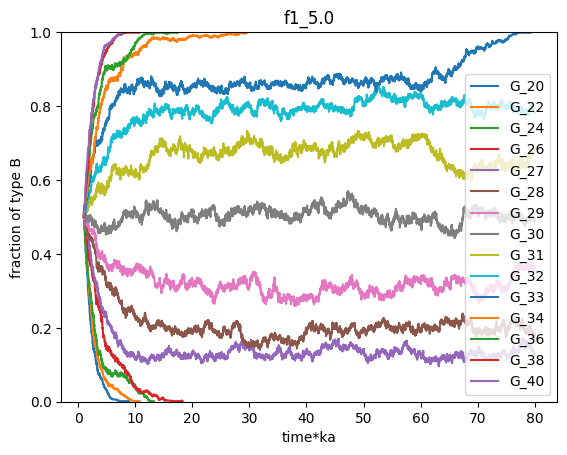

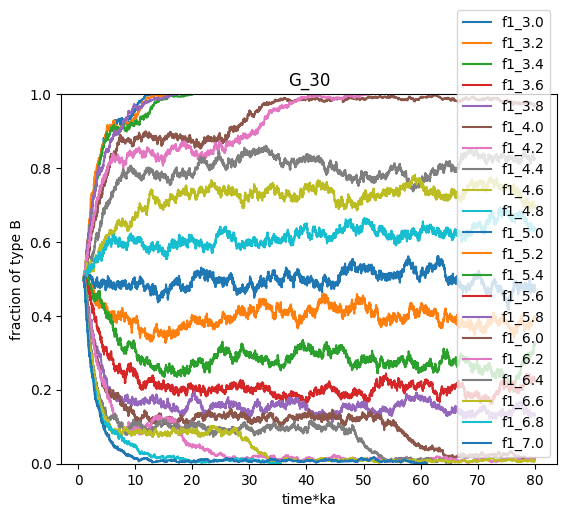

In [9]:

# 设置文件夹路径
folder_path = r'./2023-3-cross-adhesion-research/MFM/fc0/'
# 查找所有以G开头的文件夹
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
#folders.sort(key=lambda x: float(x.split("_")[1]))
# 循环遍历文件夹，读取数据并存储

G_list=[]
frac_Glist=[]
for folder in folders:
    plt.figure()
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    for sub_folder in sub_folders:
        #plt.figure()
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            plt.plot(numcells_data['time'][100:],numcells_data['fraction'][100:],label=str(sub_folder))

            if numcells_data.iloc[-1,1] <= 2 and numcells_data.iloc[-1,1] != 0:
                fraction_value = 1
            elif numcells_data.iloc[-1,2] <= 2:
                fraction_value = 0
            else:
                num_host,num_mutant =numcells_data.iloc[-6000:,1].mean(),numcells_data.iloc[-6000:,2].mean()
                fraction_value =num_mutant/(num_host+num_mutant)
            G_list.append(int(sub_folder.split('_')[-1]))
            frac_Glist.append(fraction_value)
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type B')
    plt.ylim((0,1))
    plt.legend()
print(G_list,frac_Glist)


folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('G')])
#folders.sort(key=lambda x: float(x.split("_")[1]))
# 循环遍历文件夹，读取数据并存储

f1_list =[]
frac_f1list=[]
for folder in folders:
    plt.figure()
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('f1')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    k=0
    times = 0
    for sub_folder in sub_folders:
        #plt.figure()
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            plt.plot(numcells_data['time'][100:],numcells_data['fraction'][100:],label=str(sub_folder))
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')

            if numcells_data.iloc[-1,1] <= 2 and numcells_data.iloc[-1,1] != 0:
                fraction_value = 1
            elif numcells_data.iloc[-1,2] <= 2:
                fraction_value = 0
            else:
                num_host,num_mutant =numcells_data.iloc[-6000:,1].mean(),numcells_data.iloc[-6000:,2].mean()
                fraction_value =num_mutant/(num_host+num_mutant)
            f1_list.append(float(sub_folder.split('_')[-1]))
            frac_f1list.append(fraction_value)
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type B')
    plt.ylim((0,1))
    plt.legend()
    print(f1_list,frac_f1list)

(0.0, 1.0)

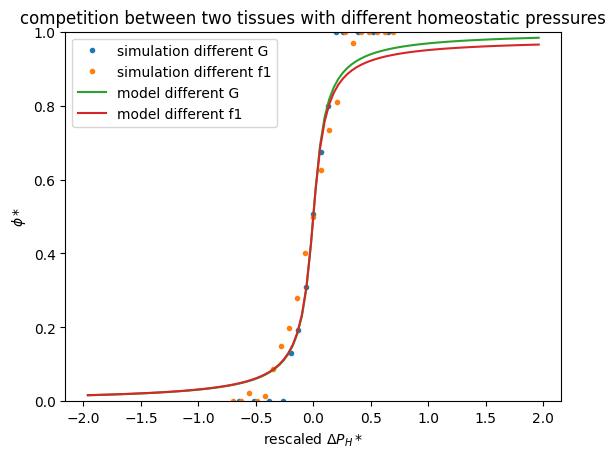

In [10]:
# Constants
a = a_fit
b = -b_fit
c = c_fit
L = 20 #system size
r = 1 #surface length
f1A = 5
f1B = 5
fc=0
GA=30
GB=30
phi0= 5/8 # The fraction of same type of the surface within the neighbors,


deltaplim= 25


P_H = 0.8295815090071099 * GA  -4.425285321119238 * f1A + 9.984763647732978

def func_phi(fc,GA,GB,f1A,f1B,L,r):
    deltaph = a*(GA-GB)-b*(f1A-f1B)
    PHA=a*GA-b*f1A+c
    PHB=a*GB-b*f1B+c
    PSA= a*GA -b*(f1A*phi0+fc*(1-phi0))+c
    PSB= a*GB -b*(f1B*phi0+fc*(1-phi0))+c
    dPSHA=PSA-PHA
    dPSHB=PSB-PHB
    x=(deltaph*L-(dPSHA+dPSHB)*r + np.sqrt(4* dPSHA*deltaph*L*r+(deltaph*L-(dPSHA+dPSHB)*r)**2))/(2*deltaph)
    return x/L

deltap_space = np.linspace(-deltaplim,deltaplim,100)
#When f1 is same, delta p = a *delta G => deltaG = delta p / a 
phi3_space_difG = func_phi(fc,GA,GA-deltap_space/a,f1A,f1B,L,r)
#When G is same and f1A=5, delta p = -b(f1A-f1B) => f1B = f1A+ delta P/b
phi3_space_diff1= func_phi(fc,GA,GB,f1A,f1A+deltap_space/b,L,r)

G_list =np.array(G_list)
deltap_glist = ((G_list-GA)*a)/P_H

f1_list =np.array(f1_list)
deltap_f1list= (f1A-f1_list)*b/P_H

plt.plot(deltap_glist,frac_Glist,'.',label='simulation different G')
plt.plot(deltap_f1list,frac_f1list,'.',label='simulation different f1')
plt.plot(deltap_space/P_H,phi3_space_difG,label='model different G')
plt.plot(deltap_space/P_H,phi3_space_diff1,label='model different f1')
plt.legend()
plt.title('competition between two tissues with different homeostatic pressures')
plt.xlabel(r'rescaled $\Delta P_H*$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)


In this figure, it's evident that the simulation results align closely with the model within the range  $0.1<\phi_<0.9$.However, beyond this range, there's a noticeable discrepancy.

The reason for this deviation lies in the fact that the minor tissue loses its structural integrity and no longer meets the condition  r<x.

To address this issue, expanding the system size would be a viable solution. A larger system size would likely provide a broader and more accurate range of $\phi$ that conforms closely to the model.


[25, 27, 29, 31, 33, 35] [0, 0.0556260000521271, 0.2545302920894525, 0.736111640617104, 0.9130662355059039, 1]
[4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0] [0.9357321945603827, 0.9170766256700867, 0.880802699949424, 0.82273653462727, 0.6995899949934936, 0.4883202655531537, 0.3207598440036175, 0.19796427889719756, 0.1348962238689436, 0.0926748227926982, 0.05539352512732115]


(0.0, 1.0)

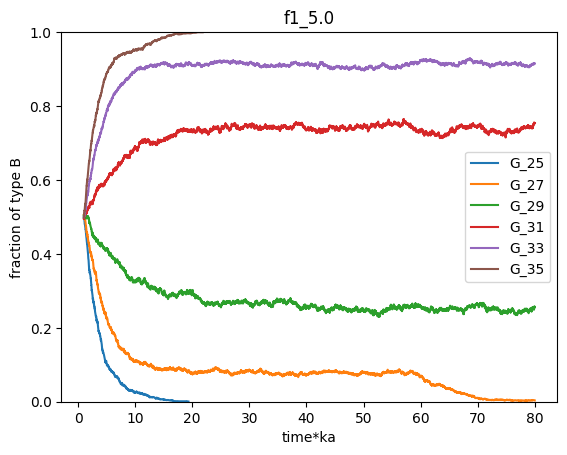

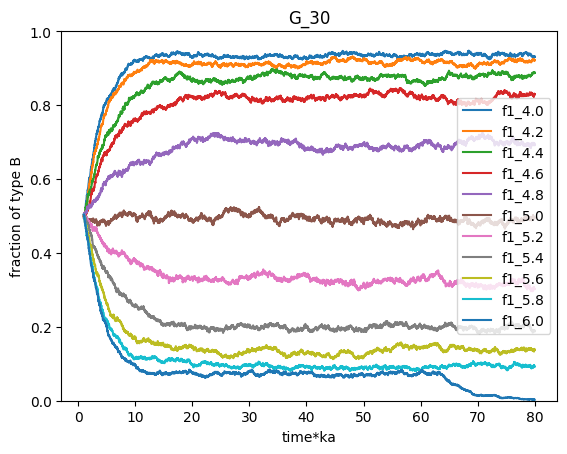

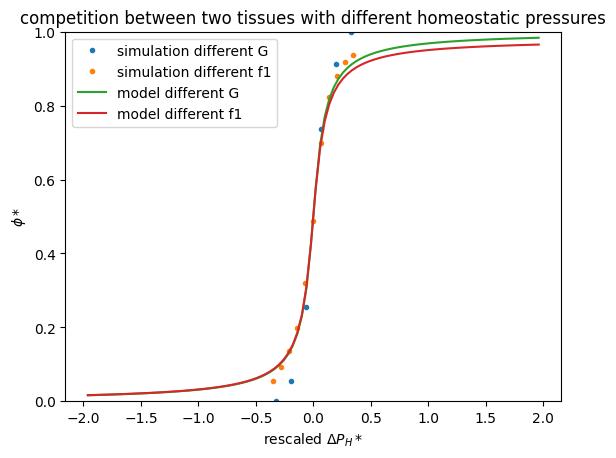

In [11]:

# 设置文件夹路径
folder_path = r'./2023-3-cross-adhesion-research//MFM/fc0_4040/'
# 查找所有以G开头的文件夹
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f1')])
#folders.sort(key=lambda x: float(x.split("_")[1]))
# 循环遍历文件夹，读取数据并存储

G_list=[]
frac_Glist=[]
for folder in folders:
    plt.figure()
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('G')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    for sub_folder in sub_folders:
        #plt.figure()
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            plt.plot(numcells_data['time'][100:],numcells_data['fraction'][100:],label=str(sub_folder))

            if numcells_data.iloc[-1,1] <= 2 and numcells_data.iloc[-1,1] != 0:
                fraction_value = 1
            elif numcells_data.iloc[-1,2] <= 2:
                fraction_value = 0
            else:
                num_host,num_mutant =numcells_data.iloc[-1000:,1].mean(),numcells_data.iloc[-6000:,2].mean()
                fraction_value =num_mutant/(num_host+num_mutant)
            G_list.append(int(sub_folder.split('_')[-1]))
            frac_Glist.append(fraction_value)
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type B')
    plt.ylim((0,1))
    plt.legend()
print(G_list,frac_Glist)


folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('G')])
#folders.sort(key=lambda x: float(x.split("_")[1]))
# 循环遍历文件夹，读取数据并存储

f1_list =[]
frac_f1list=[]
for folder in folders:
    plt.figure()
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('f1')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    k=0
    times = 0
    for sub_folder in sub_folders:
        #plt.figure()
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            numcells_data = pd.read_csv(numcells_path,sep='\t')
            numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
            numcells_data['time'] = numcells_data.iloc[:,0]/100
            plt.plot(numcells_data['time'][100:],numcells_data['fraction'][100:],label=str(sub_folder))
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')

            if numcells_data.iloc[-1,1] <= 2 and numcells_data.iloc[-1,1] != 0:
                fraction_value = 1
            elif numcells_data.iloc[-1,2] <= 2:
                fraction_value = 0
            else:
                num_host,num_mutant =numcells_data.iloc[-1000:,1].mean(),numcells_data.iloc[-6000:,2].mean()
                fraction_value =num_mutant/(num_host+num_mutant)
            f1_list.append(float(sub_folder.split('_')[-1]))
            frac_f1list.append(fraction_value)
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type B')
    plt.ylim((0,1))
    plt.legend()
    print(f1_list,frac_f1list)
    
# Constants
a = a_fit
b = -b_fit
c = c_fit
L = 40 #system size
r = 2 #surface length
f1A = 5
f1B = 5
fc=0
GA=30
GB=30
phi0= 5/8 # The fraction of same type of the surface within the neighbors,


deltaplim= 25


P_H = 0.8295815090071099 * GA  -4.425285321119238 * f1A + 9.984763647732978

def func_phi(fc,GA,GB,f1A,f1B,L,r):
    deltaph = a*(GA-GB)-b*(f1A-f1B)
    PHA=a*GA-b*f1A+c
    PHB=a*GB-b*f1B+c
    PSA= a*GA -b*(f1A*phi0+fc*(1-phi0))+c
    PSB= a*GB -b*(f1B*phi0+fc*(1-phi0))+c
    dPSHA=PSA-PHA
    dPSHB=PSB-PHB
    x=(deltaph*L-(dPSHA+dPSHB)*r + np.sqrt(4* dPSHA*deltaph*L*r+(deltaph*L-(dPSHA+dPSHB)*r)**2))/(2*deltaph)
    return x/L
plt.figure()
deltap_space = np.linspace(-deltaplim,deltaplim,100)
#When f1 is same, delta p = a *delta G => deltaG = delta p / a 
phi3_space_difG = func_phi(fc,GA,GA-deltap_space/a,f1A,f1B,L,r)
#When G is same and f1A=5, delta p = -b(f1A-f1B) => f1B = f1A+ delta P/b
phi3_space_diff1= func_phi(fc,GA,GB,f1A,f1A+deltap_space/b,L,r)

G_list =np.array(G_list)
deltap_glist = ((G_list-GA)*a)/P_H

f1_list =np.array(f1_list)
deltap_f1list= (f1A-f1_list)*b/P_H

plt.plot(deltap_glist,frac_Glist,'.',label='simulation different G')
plt.plot(deltap_f1list,frac_f1list,'.',label='simulation different f1')
plt.plot(deltap_space/P_H,phi3_space_difG,label='model different G')
plt.plot(deltap_space/P_H,phi3_space_diff1,label='model different f1')
plt.legend()
plt.title('competition between two tissues with different homeostatic pressures')
plt.xlabel(r'rescaled $\Delta P_H*$')
plt.ylabel(r'$\phi *$')
plt.ylim(0,1)


__Paper 2:Tissue evolution: mechanical interplay of adhesion, pressure, and heterogeneity__

Here I will use the theory to explain the following results

<img src="./pictures/T_Büscher_et_al0.png" alt="Alt text" style="width:600px;">

(0.0, 1.0)

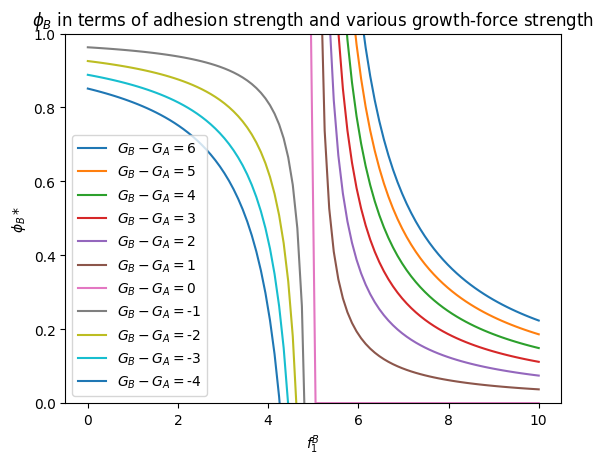

In [12]:
# Constants
a = a_fit
b = -b_fit
steps=100

f1A = np.full(steps,5)
deltaG_list=np.arange(-6,5,1)

def func_phi3(fc,deltaG,f1A,f1B):
    fc=np.minimum(f1A,f1B) # cross adhesion =min(f1A,f1B)
    return (a/b*deltaG-fc+f1B)/(f1A+f1B-2*fc)

f1B_space= np.linspace(0,10,steps)
for deltaG in deltaG_list:
    phi3_space = 1-func_phi3(fc,deltaG,f1A,f1B_space)
    plt.plot(f1B_space,phi3_space,label=r'$G_B-G_A = $'+str(-deltaG))
plt.legend()
plt.title(r'$\phi_B$ in terms of adhesion strength and various growth-force strength')
plt.xlabel(r'$f_1^B$')
plt.ylabel(r'$\phi_B *$')
plt.ylim(0,1)

<img src="./pictures/T_Büscher_et_al0.png" alt="Alt text" style="width:600px;">

>$$\Delta P= b(2f_1^C-f_1^A-f_1^B)\phi + a\Delta G + b(f_1^B-f_1^C)$$
>The stability of the FP is determined by the sign of $b(2f_1^C-f_1^A-f_1^B)$. It's stable if sign is - and vice verse.

$b(2f_1^C-f_1^A-f_1^B)<0$ because $f_1^C=min(f_1^A,f_1^B)$, so the FPs are all stable.

When comparing two figures, it's evident that the analytical results from the model align well with the intended scenario. However, a notable issue arises: for small (or large) $f_1^B$​, the expected behavior is for $\phi^*$ to approach 0 (or 1) accordingly. Surprisingly, the theoretical outcomes from the model consistently show that $\phi^*$ tends towards 0 (or 1) but never quite reaches these extremes.

The underlying explanation for this discrepancy lies in the fact that a single cell A, possessing a higher growth strength $G_A$, gains a significant advantage over the neighboring tissue B with comparatively lower adhesion strength. This advantage becomes pronounced especially when the cross-adhesion strength is determined as the minimum between the strengths of the two tissues. However, after the division of two cells, they adhere to each other, disrupting the assumption of a well-mixed system.

<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_252735/593799224.py:24: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta G$')
/tmp/ipykernel_252735/593799224.py:26: SyntaxWarning: invalid escape sequence '\p'
  ax.set_zlabel('$\phi_3$')
/tmp/ipykernel_252735/593799224.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title('$\phi_3$ vs $\Delta G$ and $f_1^C$')


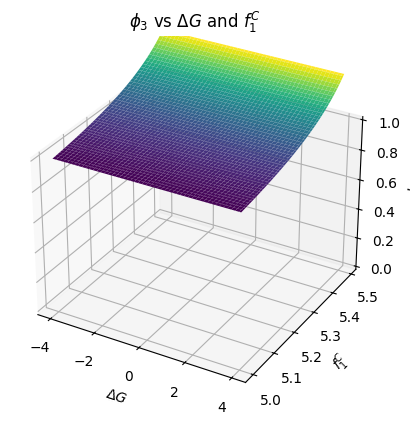

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
a = a_fit
b = -b_fit
f1A = 5
f1B = 6

# Define the function
def calculate_phi3(delta_G, f1C):
    return ((a * delta_G / b) - f1C**f1C + f1B**f1B) / (f1A**f1A + f1B**f1B - 2 * f1C**f1C)

# Generate data for plotting
delta_G_values = np.linspace(-4, 4, 100)  # Delta G values ranging from -10 to 0
f1C_values = np.linspace(5, 5.49, 100)  # f1C values ranging from 0 to 10
Delta_G, F1C = np.meshgrid(delta_G_values, f1C_values)
phi3_values = calculate_phi3(Delta_G, F1C)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Delta_G, F1C, phi3_values, cmap='viridis')
ax.set_xlabel('$\Delta G$')
ax.set_ylabel('$f_1^C$')
ax.set_zlabel('$\phi_3$')
ax.set_title('$\phi_3$ vs $\Delta G$ and $f_1^C$')
ax.set_zlim(0, 1)
plt.show()


1. design an experiment

2. calculate the average

The set up of following simulations are:

Type A: $G = 30, f_1^A = 5.0$

Type B: $G = 34, f_1^B = 6.0$

cross adhesion strength $f_1^C = 5.0,5.1,5.2,...,6.0$

Initial fraction of type B: $\phi_{ini}= 0.1,0.2,...,0.9$

Goal: investigate the effect of $f_1^C $ and $\phi_{ini}$ on competition result $\phi_B$

Prelimnary results:

Regime 1: In the range $f_c = 5.0, 5.1$, competition result $\phi_B$ converge to equilibrium balance,no matter what the value of $\phi_{ini}$.

Regime 2: In the range $f_c = 5.2, 5.3,...,5.6$, competition result $\phi_B$ always converge to 1,no matter what the value of $\phi_{ini}$.

Regime 3: In the range $f_c = 5.7,5.8,5.9,6.0$,competition result $\phi_B$ deverge to 0,1 depending on the value of $\phi_{ini}$.


Questions:

1. What factors do determine $\phi_{ini}^{bifur}$ in regime 3 and how?

2. What factors do determine $\phi_B^{equil}$ in the regime 1 and how?

3. What factors do determine $f_c^{bifur}$ from regime 2 to regime 3 and how?

Goal: examine the theory by two formulas

examine the dynamics:
$$\partial _t \phi = s(\phi) \phi (1-\phi)$$
exmaine the prssure:
$$P = \phi P_{eff}^A(\phi) + (1-\phi) P_{eff}^B(\phi)$$

Text(0, 0.5, '$\\phi$')

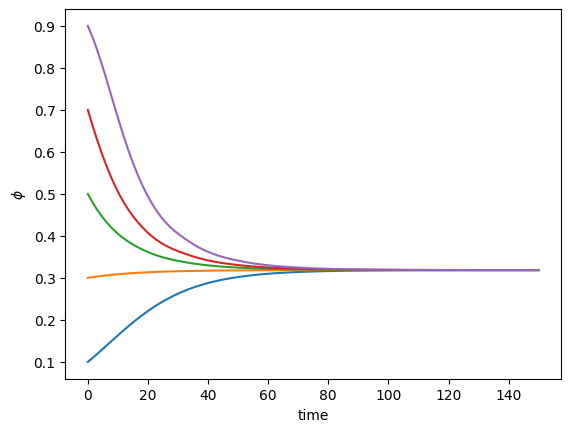

In [18]:
kappa,PHA,PHB =0.0005698083386401133, a*30+b*5+c,a*34+b*6+c
dksa,dksb = 0.1,0.2

def func_homogeneous_competition(t,phi):
    selc_coeff = kappa * (PHA-PHB) +dksa - phi * (dksa+dksb)
    dphi_dt = selc_coeff * phi * (1-phi)
    return dphi_dt

x_span = (0,150)
y0_list = [0.1+i*0.2 for i in range (5)]
sol = solve_ivp(func_homogeneous_competition,x_span,y0_list,t_eval = np.linspace(x_span[0],x_span[1],100))

for i in range(5):
    plt.plot(sol.t,sol.y[i],label='')
plt.xlabel('time')
plt.ylabel(r'$\phi$')

optimized parameters (dksa,dksb:) [0.06065861 0.175634  ]


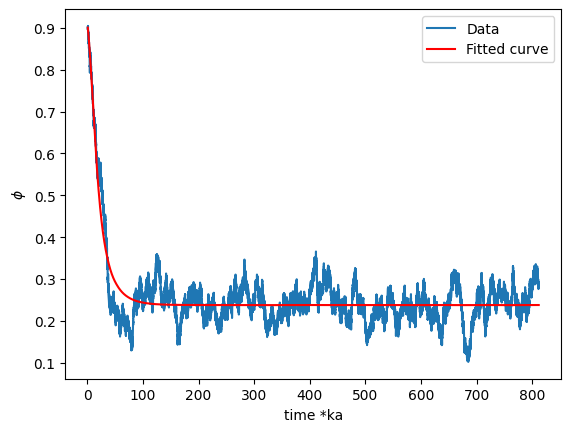

In [15]:
kappa,PHA,PHB = 0.05698083386401133,a*30+b*5+c,a*34+b*6+c

def func_homogeneous_competition(t,phi,dksa,dksb):
    selc_coeff = kappa * (PHA-PHB) +dksa - phi * (dksa+dksb)
    dphi_dt = selc_coeff * phi * (1-phi)
    return dphi_dt

def model_function(params,t_data):
    dksa,dksb = params
    sol = solve_ivp(lambda t,phi: func_homogeneous_competition(t,phi,dksa,dksb),[t_data[0],t_data[-1]],[phi0],t_eval=t_data)
    return sol.y[0]

def loss_function(params,t_data,phi_data):
    phi_model = model_function(params,t_data)
    return np.sum((phi_model-phi_data)**2)

numfile_path=r'./2023-3-cross-adhesion-research/ld3_longertime/G_34/f12_5.0/frac_0.1/numcells.dat'

data = pd.read_csv(numfile_path,sep='\t')
t_data = (data.iloc[:,0].values/100)[100:]
phi_data = (data.iloc[:,1]/(data.iloc[:,2]+data.iloc[:,1])).values[100:]
phi0 = phi_data[0]
initial_guess = [0.1,0.2]

result = minimize(loss_function,initial_guess,args=(t_data,phi_data))

plt.plot(t_data,phi_data,label = 'Data')
plt.plot(t_data,model_function(result.x,t_data),'r-',label = 'Fitted curve')
plt.xlabel('time *ka')
plt.ylabel(r'$\phi$')
plt.legend()
print(r'optimized parameters (dksa,dksb:)',result.x)

./2023-3-cross-adhesion-research/ld3_longertime/G_34repeat/
['f12_6.0']
current folder  f12_6.0
current subfolder  frac_0.1
current subfolder  frac_0.3
[-0.52881764 -0.23054263]
current subfolder  frac_0.5
[0.01792841 0.83128097]
current subfolder  frac_0.7
[-0.39964716 -0.19161096]
current subfolder  frac_0.9
[-0.5701491  -0.15978723]


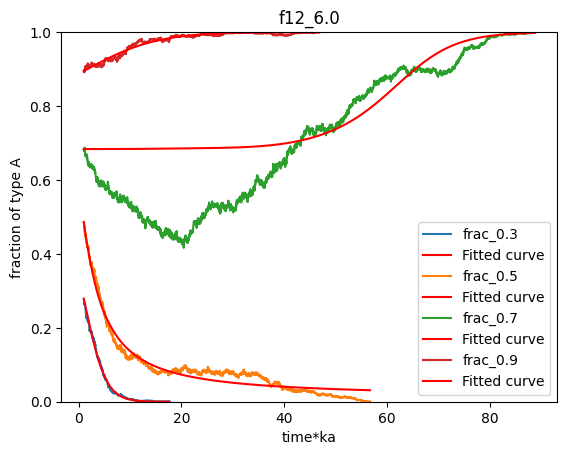

In [17]:
# 设置文件夹路径
folder_path = r'./2023-3-cross-adhesion-research/ld3_longertime/G_34repeat/'
# 查找所有以G开头的文件夹
print(folder_path)
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('f12_6.0')])
print(folders)
#folders.sort(key=lambda x: float(x.split("_")[1]))

f12_list =[]
k_aver_list=[]
for folder in folders:
    plt.figure()
    print('current folder ',folder)
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('frac')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    k=0
    times = 0
    for sub_folder in sub_folders:
        #plt.figure()
        print('current subfolder ',sub_folder)
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            data = pd.read_csv(numcells_path,sep='\t')
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')
           
            t_data = (data.iloc[:,0].values/100)[100:]
            phi_data = (data.iloc[:,1]/(data.iloc[:,2]+data.iloc[:,1])).values[100:]
            phi0 = phi_data[0]
            initial_guess = [0.1,0.2]
            result = minimize(loss_function,initial_guess,args=(t_data,phi_data))
            plt.plot(t_data,phi_data,label=str(sub_folder))
            plt.plot(t_data,model_function(result.x,t_data),'r-',label = 'Fitted curve')
            print(result.x)
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type A')
    plt.ylim((0,1))
    plt.legend()

In [ ]:
# 设置文件夹路径
folder_path = r'./2023-2-crossinteraction/'
# 查找所有以G开头的文件夹
print(folder_path)
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and f.startswith('frac')])
print(folders)
#folders.sort(key=lambda x: float(x.split("_")[1]))
# 循环遍历文件夹，读取数据并存储
def func(x,k,b):
    return k*x+b

f12_list =[]
k_aver_list=[]
for folder in folders:
    plt.figure()
    print('current folder ',folder)
    sub_folders = sorted([f for f in os.listdir(os.path.join(folder_path, folder)) if os.path.isdir(os.path.join(folder_path, folder, f)) and f.startswith('frac')])
    sub_folders.sort(key=lambda x: float(x.split("_")[1]))
    k=0
    times = 0
    for sub_folder in sub_folders:
        #plt.figure()
        print('current subfolder ',sub_folder)
        # 读取numcells.dat文件中的数据
        numcells_path = os.path.join(folder_path, folder, sub_folder, 'numcells.dat')
        try:
            data = pd.read_csv(numcells_path,sep='\t')
            #plt.savefig('./'+folder+'/'+folder+sub_folder+'.png')
           
            t_data = (data.iloc[:,0].values/100)[100:]
            phi_data = (data.iloc[:,1]/(data.iloc[:,2]+data.iloc[:,1])).values[100:]
            phi0 = phi_data[0]
            initial_guess = [0.1,0.2]
            result = minimize(loss_function,initial_guess,args=(t_data,phi_data))
            plt.plot(t_data,phi_data,label=str(sub_folder))
            plt.plot(t_data,model_function(result.x,t_data),'r-',label = 'Fitted curve')
            print(result.x)
        except:
            continue
    plt.title(folder)
    plt.xlabel('time*ka')
    plt.ylabel('fraction of type A')
    plt.ylim((0,1))
    plt.legend()

**Rock-paper-scissors game**

In the game of rock-paper-scissors, we know that rock defeats scissors, scissors defeats paper, and paper defeats rock. In the context of tissue competition, we can analogously assess the competitive advantages of tissues using a concept called homeostatic pressure. This pressure represents the equilibrium point in the system where the division rate equals the death rate. Consequently, tissues with higher homeostatic pressure tend to prevail.

However, if we introduce another parameter like cross-adhesion force into the equation, the outcome of the competition could be altered. This additional factor may lead to a scenario analogous to rock-paper-scissors within tissue competition dynamics.

In the context of a well-mixed system with three tissues (labeled 1, 2, and 3), we can approximate the average pressure of tissue i as:
$$ P_i = a G - b\sum_j \phi_j f_1^{ij} + c $$

Considering three distinct systems with pairwise tissue competitions (1 vs. 2, 2 vs. 3, and 3 vs. 1), we can evaluate the pressure differences as follows:

For the competition between tissue 1 and tissue 2 in system 1, the pressure difference ($\Delta P_{12}$) can be computed as:

$$\Delta P_{12}(\phi_1)= b(2f_1^{12}-f_1^{11}-f_1^{22})\phi_1 + a\Delta G_{12} + b(f_1^{22}-f_1^{12})$$

Similarly, for the competitions in the other two systems:

$$\Delta P_{23}(\phi_2)= b(2f_1^{23}-f_1^{22}-f_1^{33})\phi_2 + a\Delta G_{23} + b(f_1^{33}-f_1^{23})$$
$$\Delta P_{31}(\phi_3)= b(2f_1^{13}-f_1^{33}-f_1^{11})\phi_3 + a\Delta G_{31} + b(f_1^{11}-f_1^{13})$$

We define tissue 1 wins against tissue 2 if $\Delta P_{12}>0$ for all $\phi_1$. By analyzing the formulas, it becomes evident that $\Delta P_{12}(\phi)$ is a linear function of $\phi_1$.Consequently, we derive that $\Delta P_{12}(\phi_1 = 0) >0$ and $ \Delta P_{12}(\phi_1 = 1) >0$ if $\Delta P_{12}>0$ for all $\phi_1$. 

\begin{equation}
\Delta P_{12}(\phi_1=0) = a\Delta G_{12} + b(f_1^{22}-f_1^{12}) > 0 \tag{1}
\end{equation}

\begin{equation}
\Delta P_{12}(\phi_1=1) = a\Delta G_{12} + b(f_1^{22}-f_1^{12}) +b(2f_1^{12}-f_1^{11}-f_1^{22})> 0 \tag{2}
\end{equation}


If we want to achieve the rock-paper-scissors set up that tissue 1 wins against tissue 2,tissue 2 wins against tissue 3, tissue 3 wins against tissue 1, then we would have:
\begin{equation}
\Delta P_{23}(\phi_2=0) = a\Delta G_{23} + b(f_1^{33}-f_1^{23}) > 0 \tag{3}
\end{equation}

\begin{equation}
\Delta P_{23}(\phi_2=1) = a\Delta G_{23} + b(f_1^{33}-f_1^{23}) +b(2f_1^{23}-f_1^{22}-f_1^{33})> 0 \tag{4}
\end{equation}

\begin{equation}
\Delta P_{31}(\phi_3=0) = a\Delta G_{31} + b(f_1^{11}-f_1^{13}) > 0 \tag{5}
\end{equation}

\begin{equation}
\Delta P_{31}(\phi_3=1) = a\Delta G_{31} + b(f_1^{11}-f_1^{13}) +b(2f_1^{13}-f_1^{33}-f_1^{11})> 0 \tag{6}
\end{equation}

Summing up the equations (1),(3),(5) yields:
\begin{equation}
\Delta P_{12}(\phi_1=0) + \Delta P_{23}(\phi_2=0) +\Delta P_{31}(\phi_3=0) = b(f_1^{11}+f_1^{22}+f_1^{33}-f_1^{12}-f_1^{23}-f_1^{13})>0 \tag{7}
\end{equation}
due to $\Delta G_{12}+\Delta G_{23}+\Delta G_{31}=0$

Summing up the equations (2),(4),(6) results in:
\begin{equation}
\Delta P_{12}(\phi_1=1) + \Delta P_{23}(\phi_2=1) +\Delta P_{31}(\phi_3=1) = b(f_1^{12}+f_1^{23}+f_1^{13}-f_1^{11}-f_1^{22}-f_1^{33})>0 \tag{8}
\end{equation}

Formulas (7) and (8) are contradictory, indicating that a Rock-paper-scissors game does not manifest in a well-mixed system.

One example of homeostatic pressure theory

1. show the evolution of cell fration and its analytical results
2. show the evolution of system pressure and its analytical results

0.20111820310735576


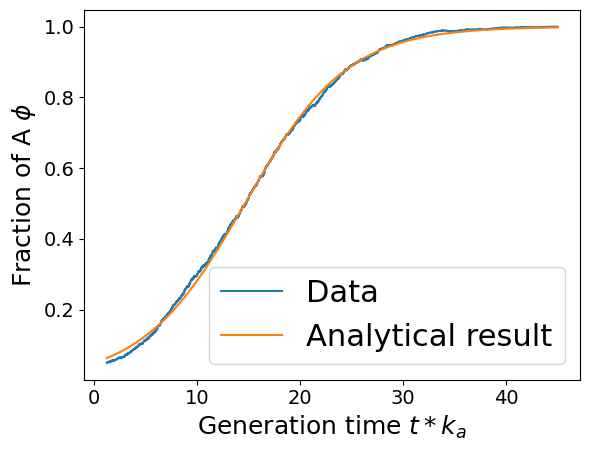

In [34]:
folder_path = './2023-11-simple-competition/example_largesystem/src'
# Constants
a_fit = 0.8255197434137439
b_fit = -4.433211634010404
c_fit = 10.164378211438262
a = a_fit
b = -b_fit

def fit_func(t,kph):
    phi = 1/(1+np.exp(-kph*t)*19)
    return phi

def fit_kappa(ph,kappa):
    kph = kappa*ph
    return kph

# evolution of cell fraction
numcells_path = folder_path+'/numcells.dat'
numcells_data = pd.read_csv(numcells_path,sep='\t')
numcells_data['fraction'] = numcells_data.iloc[:,2]/(numcells_data.iloc[:,2]+numcells_data.iloc[:,1])
numcells_data['time'] = numcells_data.iloc[:,0]/100
time_data = numcells_data['time'][120:]
fraction_data = numcells_data['fraction'][120:]
  # data 
plt.plot(time_data,fraction_data,label='Data')
plt.xlabel(r'Generation time $t*k_a$',fontsize=18)
plt.ylabel(r'Fraction of A $\phi$',fontsize=18)
  # analytical result
popt,pcov = curve_fit(fit_func,time_data,fraction_data)
fit_fraction_data = fit_func(time_data,*popt)
plt.plot(time_data,fit_fraction_data,label='Analytical result')
plt.legend(fontsize=22)
kph = popt[0]
print(kph)


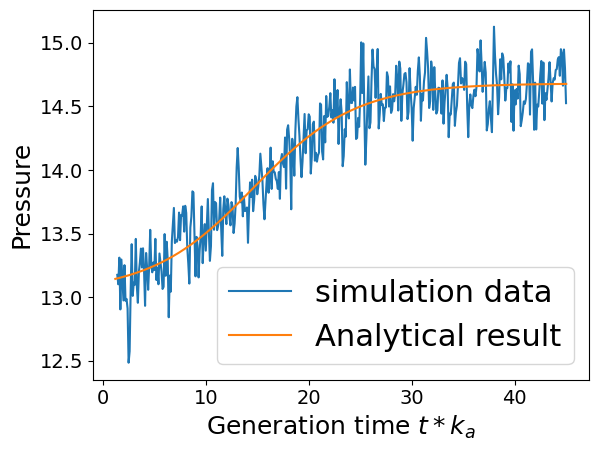

In [37]:
def fit_pressure(t,PHA,PHB):
    phi=fit_func(t,kph)
    return phi*PHA+(1-phi)*PHB

# evolution of pressure
plt.figure()
pressure_path = folder_path + '/__curp.dat'
pressure_data = pd.read_csv(pressure_path,sep='\t')
  # data
time_data_pressure = pressure_data.iloc[12:,0]/100
col_pressure_data = pressure_data.iloc[12:,1]
plt.plot(time_data_pressure,col_pressure_data,label='simulation data')

plt.xlabel('Generation time $t*k_a$',fontsize = 18)
plt.ylabel('Pressure',fontsize = 18)
  # analytical result
popt_pressure,pcov = curve_fit(fit_pressure,time_data_pressure,col_pressure_data)
fit_pressure_data = fit_pressure(time_data,*popt_pressure)
plt.plot(time_data,fit_pressure_data,label='Analytical result')

plt.legend(fontsize=22)